# QR Algorithm and an Application

You have read about the QR alogorithm, a computational technique for accounting eigenvectors and eigenvalues. To implement the algorithm, we first need to write an algorithm for the QR decomposition. 

Exercise 6.8 describes the process of QR decomposition in some detail, but does not provide code. Let's code it.

The process in Exercise 6.8 obviously lends itself to being iterative. We'll define three matrices: U, Q, and R. Q and R are obvious, U will store the vectors $\vec{u}$ needed to build up the vectors $\vec{q}$ and the matrix R.

For each iteration, we first copy over the vector $\vec{a_i}$ to $\vec{u_i}$. Next we need the magnitude $|\vec{u_i}|$, and since these are precisely the diagonal elements of R, we'll store the magnitude there. Now we can calculate $\vec{q_i}$ trivially. Finally we need to calculate the off-diagonal elements of R, and if i > 0, we have more terms in $\vec{u_i}$. We're going to be unnecessarily clever for $\vec{u_i}$. Notice all the terms we need to calculate it are calculated elsewhere, so we'll re-use them.

In [1]:
import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

def QR(A):
    N = A.shape[0]
    U = np.empty([N,N])
    Q = np.empty([N,N])
    # R is upper triangular so we won't populate half, it's convenient to begin with zeroes
    R = np.zeros([N,N])

    for i in range(N):
        U[:,i] = A[:,i]
        # remember i starts at 0, feel free to try a for loop for range(0) if you don't understand the magic
        for j in range(i):
            R[j,i] = np.dot(Q[:,j], A[:,i])
            U[:,i] -= R[j,i] * Q[:,j]
        R[i,i] = np.sqrt(np.dot(U[:,i], U[:,i]))
        Q[:,i] = U[:,i] / R[i,i]
    
    return Q, R

The second part of the QR algorithm is simply calling the QR function over and over until we hit a desired precision. We'll use the matrix given in Exercise 6.8

In [7]:
def QReigen(A, verbose=False):
    epsilon = 1e-6
    
    N = A.shape[0]
    
    V = np.identity(N, float)
    delta = 100.0
    runs = 0
    while runs < 1000:
        runs += 1
        Q, R = QR(A)

        A = np.dot(R, Q)
        V = np.dot(V, Q)
    
        # find max of the off-diagonal elements
        Ac = np.copy(A)
        for i in range(N):
            Ac[i,i] = 0.0
        # if delta < np.max(np.absolute(Ac)):
        #     assert False, "it's dead jim"
        delta = np.max(np.abs(Ac))
        if verbose:
            print(delta)
        if delta < epsilon:
            break

    eigenvals = [A[i,i] for i in range(N)]
    return eigenvals, V

A = [[1, 4, 8, 4],
     [4, 2, 3, 7],
     [8, 3, 6, 9],
     [4, 7, 9, 2]]

A = np.array(A, float)

eigenvals, V = QReigen(A, verbose=True)

print(eigenvals)
print(V)

9.07463238459728
3.730208387990888
1.4247273120286912
0.5428845995902339
0.20682135151234915
0.0787896241858275
0.030015129569934962
0.01143433725439016
0.004355938136424395
0.001659405012558022
0.0006321542910052405
0.00024082068231258584
9.174121232354013e-05
3.4949033261553105e-05
1.33139174452124e-05
5.071968545896978e-06
1.9321785059088246e-06
7.360679975905002e-07
[np.float64(20.99999999999998), np.float64(-7.999999999999981), np.float64(-3.0), np.float64(0.9999999999999999)]
[[ 0.432 -0.384 -0.775 -0.258]
 [ 0.384  0.432 -0.258  0.775]
 [ 0.623  0.527  0.258 -0.516]
 [ 0.527 -0.623  0.516  0.258]]


## SVD (Singular Value Decomposition)

The idea behind SVD is that any matrix $A$ can be expressed as the the product of a set of vectors. Given a matrix $A$ of size $ m \times n$:

$$
A = U \Sigma V^T
$$

Where:
- $U$ is an $ m \times m$ orthogonal matrix whose columns are the left singular vectors of A
- $\Sigma$ is a a diagonal $ m \times n$ matrix containing the singular values of A in descending order
- $V^T$ is the transpose of an $n \times n$ orthogonal matrix where the columns are the right singular vectors of A.

The singular values turn out to closely related to the eigenvalues of $A A^T$, and the vectors that make up U are *exactly* the eigenvectors of $A A^T$.

The vectors that make up $V$ are the eigenvectors of $A^T A$.

This is all we need to write down a function to compute SVD.

In [8]:
def svd(A):
    A_t = np.transpose(A)
    right_vals, right_vecs =  QReigen(np.matmul(A, A_t))
    left_vals, left_vecs =  QReigen(np.matmul(A_t, A))

    U = right_vecs
    V_t = np.transpose(left_vecs)

    if len(left_vals) > len(right_vals):
        sigma = np.sqrt(np.array(right_vals))
        for i in range(len(sigma)):
            if np.abs(sigma[i]) < 1e-8 or np.isnan(sigma[i]):
                sigma[i] = 0
        V_t = V_t[:len(right_vals)]
    else:
        sigma = np.sqrt(np.array(left_vals))
        for i in range(len(sigma)):
            if np.abs(sigma[i]) < 1e-8 or np.isnan(sigma[i]):
                sigma[i] = 0
        U = U[:,:len(left_vals)]

    return U, sigma, V_t

Testing this function is trivial. If we can reconstruct the initial matrix, we've succeeded.

Of course there is a numpy implementation of SVD. We can verify our answers are similar.

In [9]:
test = np.array([[3, 2, 2],
                 [2, 3, -2]], float)
U, sigma, V_t = svd(test)
print(U)
print(sigma)
print(V_t)
print(np.dot(U * sigma, V_t))

U, sigma, V_t = np.linalg.svd(test, full_matrices=False)
print(U)
print(sigma)
print(V_t)
print(np.dot(U * sigma, V_t))

[[ 0.707 -0.707]
 [ 0.707  0.707]]
[5. 3.]
[[ 0.707  0.707 -0.   ]
 [-0.236  0.236 -0.943]]
[[ 3.  2.  2.]
 [ 2.  3. -2.]]
[[-0.707 -0.707]
 [-0.707  0.707]]
[5. 3.]
[[-0.707 -0.707  0.   ]
 [-0.236  0.236 -0.943]]
[[ 3.  2.  2.]
 [ 2.  3. -2.]]


There is little utility in decomposing a small matrix into it's component parts. But as matrices become more complex, the utility of extracting a smaller set of vectors that can accuratel express the entire matrix becomes clear. This is for example one way to compress 2D images!

Note below our code doesn't do quite as well for this larger matrix. This is mostly a function of the author not having infinite time! Some careful handling of the ordering of vectors would probably improve the result.

But of course the numpy implementation works great! So we can "graduate" to using it.

In [10]:
test = np.array([[1, 1, 1, 0, 0],
                 [3, 3, 3, 0, 0],
                 [4, 4, 4, 0, 0],
                 [5, 5, 5, 0, 0],
                 [0, 2, 0, 4, 4],
                 [0, 0, 0, 5, 5],
                 [0, 1, 0, 2, 2]], float) 

U, sigma, V_t = svd(test)

print(np.dot(U * sigma, V_t), "\n\n\n")

U, sigma, V_t = np.linalg.svd(test, full_matrices=False)

print(np.dot(U * sigma, V_t))

[[ 0.602  0.635  0.602  0.101  0.101]
 [ 1.805  1.906  1.805  0.304  0.304]
 [ 2.406  2.542  2.406  0.405  0.405]
 [ 3.008  3.177  3.008  0.506  0.506]
 [ 0.897  0.874  0.897 -0.176 -0.176]
 [ 0.592  0.536  0.592 -0.294 -0.294]
 [ 0.449  0.437  0.449 -0.088 -0.088]] 



[[ 1.  1.  1.  0.  0.]
 [ 3.  3.  3. -0. -0.]
 [ 4.  4.  4. -0. -0.]
 [ 5.  5.  5.  0.  0.]
 [-0.  2. -0.  4.  4.]
 [-0.  0. -0.  5.  5.]
 [-0.  1. -0.  2.  2.]]


/var/folders/1k/rdwyb7sd6hq23xhhtb7j4y100000gq/T/ipykernel_20218/2342042725.py:16: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.array(left_vals))


Now time for some dimensionality reduction. Looking at our data

In [11]:
print(sigma)

[12.481  9.509  1.346  0.     0.   ]


Two of our singular values are 0. One of them is very small compared to the others. Can we accurately create the whole matrix from two vectors?

In [ ]:
U, sigma, V_t = np.linalg.svd(test, full_matrices=False)

k = 2

U = U[:,:k]
V_t = V_t[:k]
sigma = sigma[:k]

print(np.dot(U * sigma, V_t))

# Application: PCA

PCA (Principle Component Analysis) is a well known algorithm often lumped into the "machine learning" category, but as with many algorithms lumped into that category, there isn't a lot of learning going on; it is just a simple algorithm using eigenvector decomposition.

The following exercises are shamelessly borrowed from [This notebook](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.09-Principal-Component-Analysis.ipynb).

In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits

digits = load_digits()

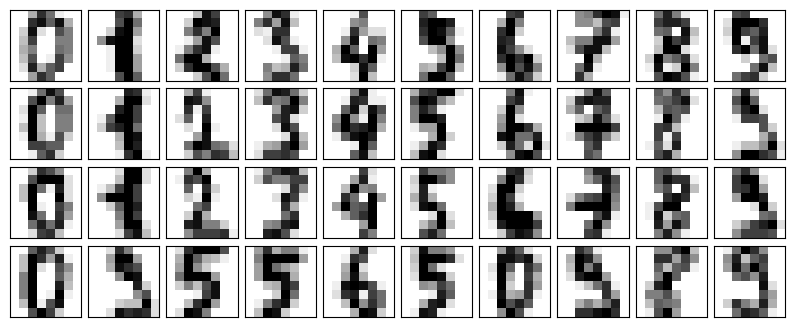

In [16]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

Now add some noise and plot noisy data.

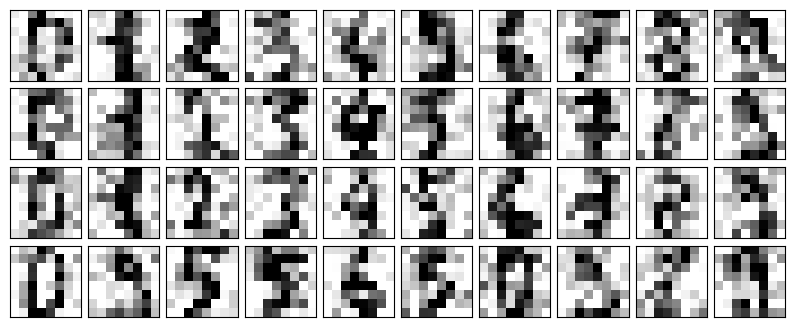

In [17]:
rng = np.random.default_rng(42)
noisy = rng.normal(digits.data, 4)
plot_digits(noisy)

The sklearn PCA package has builtin functionality to determine a reasonable amount of dimensionality reduction.

The code below computes the number of components required to account for 50% of the variance.

In [24]:
pca = PCA(0.50).fit(noisy)
pca.n_components_

np.int64(12)

Now we can reconstruct the original data from only those components.

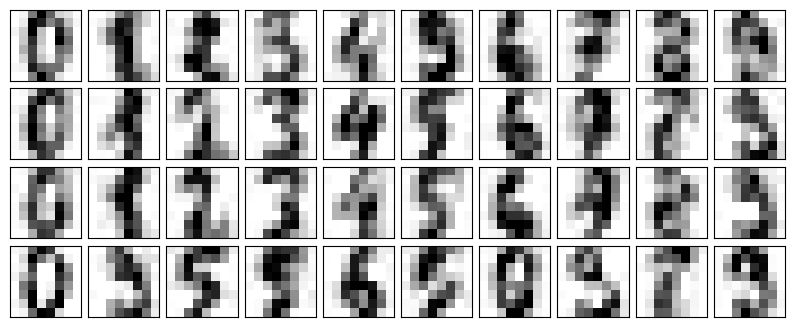

In [26]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

A bit noisy. The more interesting example is

## Eigenfaces

The same principle used to reconstruct the numbers can be used to reconstruct any image.

In the number example, there are initially 64 dimensions (64 pixels with a single number describing opacity in each pixel). 12 eigenvectors was sufficient to account for 50% of the variance in 64 pixels; a notably impressive result. What do we need to describe more complicated images?

In [27]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


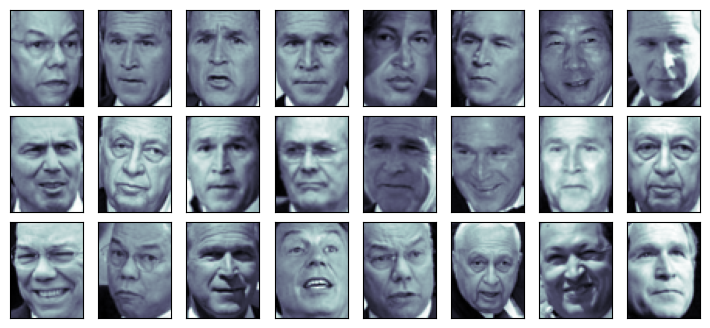

In [28]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(faces.data[i].reshape(62, 47), cmap='bone')

In [29]:
pca = PCA(150, svd_solver='randomized', random_state=42)
pca.fit(faces.data)

PCA(n_components=150, random_state=42, svd_solver='randomized')

There is now a set of 150 component eigenvectors which can in theory be used to re construct the faces. 

It is interesting to view these "eigenfaces".

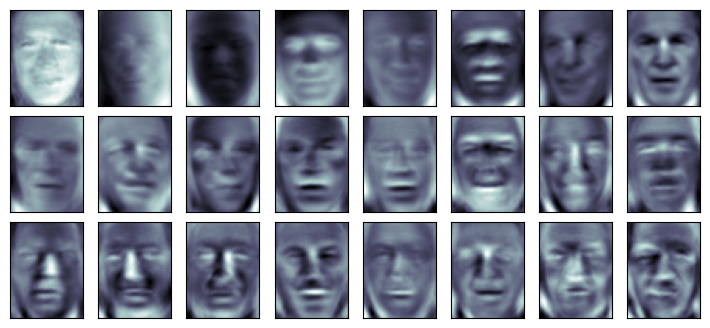

In [30]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

Text(0, 0.5, 'cumulative explained variance')

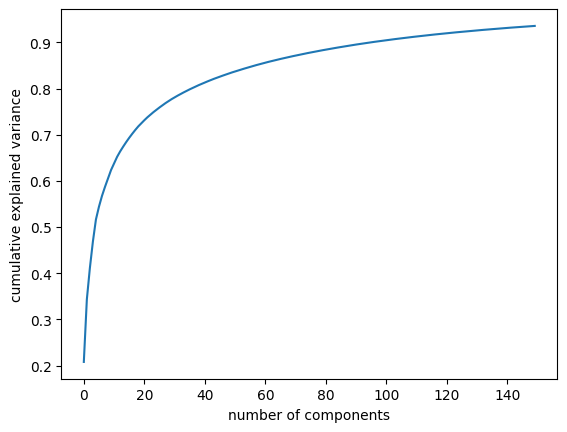

In [31]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

The plot tells us the 150 components computed account for some 90% of the data, suggesting we can reconstruct the faces quite well.

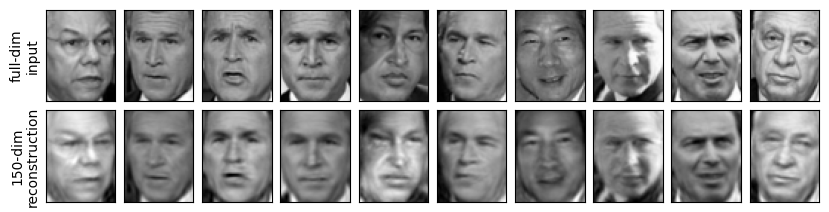

In [32]:
pca = pca.fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');